In [3]:
from dataclasses import dataclass
from enum import StrEnum
from datetime import datetime, timedelta
import polars as pl
from collections import defaultdict, Counter
from typing import Tuple
from common.constants.column_types import (
    CPZP_SCHEMA,
    OZP_SCHEMA,
    POHLAVI_CPZP,
    TYP_UDALOSTI,
)
from common.constants.column_names import SHARED_COLUMNS, OZP_COLUMNS, CPZP_COLUMNS
import pickle
from common.constants.objects import (
    Person,
    Gender,
    AgeCohort,
    Prescription,
    PrescriptionType,
)
import matplotlib.pyplot as plt
import numpy as np
import os

pl.Config.set_tbl_rows(20)
pl.Config.set_tbl_cols(60)

from typing import Any

POJISTOVNA = "cpzp"

In [4]:
with open(f"./DATACON_data/{POJISTOVNA}_persons.pkl", "rb") as f:
    persons: list[Person] = pickle.load(f)

In [7]:
# --- Příprava pojištěneckých roků ---
insurance_rows = []
for p in persons:
    start = p.zahajeni_pojisteni
    end = min(p.ukonceni_pojisteni, datetime(2023, 12, 31).date())
    current = datetime(start.year, 1, 1).date()

    while current.year <= end.year:
        year_start = max(current, datetime(current.year, 1, 1).date())
        year_end = min(end, datetime(current.year, 12, 31).date())
        if year_end >= year_start:
            days = (year_end - year_start).days + 1
            insurance_rows.append(
                {
                    "year": current.year,
                    "insured_days": days,
                    "person_id": p.id,
                    "age_cohort": p.age_cohort.value,
                }
            )
        current = datetime(current.year + 1, 1, 1).date()

insurance_df = pl.DataFrame(insurance_rows)

# --- Spotřeba kortikoidů ---
rx_rows = []
for p in persons:
    for rx in p.prescriptions:
        if rx.prescription_type == PrescriptionType.KORTIKOID and rx.prednison_equiv:
            rx_rows.append(
                {
                    "year": rx.date.year,
                    "prednison_equiv": rx.prednison_equiv,
                    "age_cohort": rx.age_cohort_at_prescription.value,
                    "person_id": p.id,
                }
            )

rx_df = pl.DataFrame(rx_rows)

# --- Agregace ---
insured_years = insurance_df.group_by("year").agg(
    (pl.col("insured_days").sum() / 365).alias("insured_person_years")
)

total_prednison = rx_df.group_by("year").agg(
    pl.col("prednison_equiv").sum().alias("total_prednison_equiv")
)

# --- Spojení a normalizace ---
summary = (
    insured_years.join(total_prednison, on="year", how="left")
    .with_columns(
        (pl.col("total_prednison_equiv") / pl.col("insured_person_years") * 1000).alias(
            "prednison_per_1000_person_years"
        )
    )
    .sort("year")
)

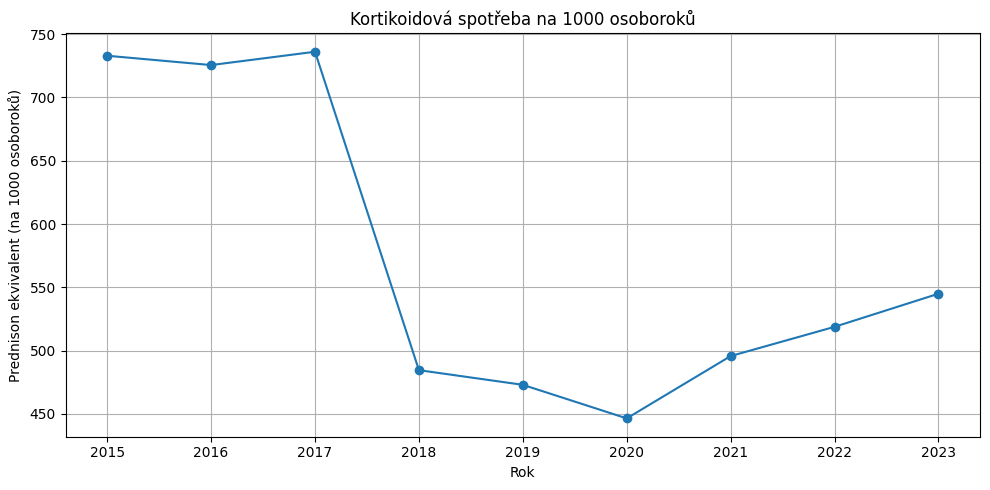

In [9]:
filtered = summary.filter(pl.col("prednison_per_1000_person_years").is_not_null())

# Plot
plt.figure(figsize=(10, 5))
plt.plot(summary["year"], summary["prednison_per_1000_person_years"], marker="o")
plt.title("Kortikoidová spotřeba na 1000 osoboroků")
plt.xlabel("Rok")
plt.ylabel("Prednison ekvivalent (na 1000 osoboroků)")
plt.grid(True)
plt.tight_layout()
plt.show()